# Importing python libraries and the PySB model.

In [1]:
# Importing libraries
from jnk3_no_ask1 import model
import numpy as np
import matplotlib.pyplot as plt
from pysb.simulator import ScipyOdeSimulator
import pandas as pd

# Here we load the fitted parameters that we obtained using the Particle Swarm Optimization (PSO). To obtain this parameter set we used the two sets that Nicole gave us. The first set has the following proteins:
* Arrestin
* MKK4
* MKK7
* JNK3

# The second set of experiments has the following proteins:
* MKK4
* MKK7
* JNK3

# Using this experimental data we defined a cost function whose value is roughly the squared difference between the experimental data and the simulations. This gave us values for the kinetic parameters of the model

# Note: The model calibration was done assuming that all the reactions are diffusion limited. Which means that we set all the k_forward (k_on) to 1.5E4 inversed microM * s

In [2]:
# Loading fitted parameters
param_values = np.array([p.value for p in model.parameters])
idx_pars_calibrate = [15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 33, 35]
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

fitted_pars = np.load('jnk3_noASK1_calibrated_pars_arr_noarr.npy')
param_values[rates_of_interest_mask] = 10 ** fitted_pars

# Next, we present a plot of the results of the model calibration. The continuous lines represent the model simulations and the dots represent the experimental data.

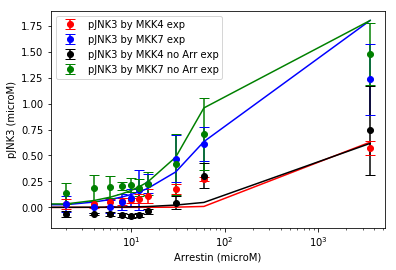

In [3]:
exp_data = pd.read_csv('../data/exp_data_arrestin_noarrestin.csv')

tspan0 = [0, 2, 4, 6, 8, 10, 12, 15, 30, 60, 3600]
solver0 = ScipyOdeSimulator(model, tspan=tspan0)
sim = solver0.run(param_values=param_values).all
arrestin_idx = [36]
plt.semilogx(exp_data['Time (secs)'].values, sim['pTyr_jnk3'], color='red')
plt.errorbar(exp_data['Time (secs)'].values, exp_data['pTyr_arrestin_avg'].values,
             exp_data['pTyr_arrestin_std'].values,
             linestyle='None', marker='o', capsize=5, color='red', label='pJNK3 by MKK4 exp')
plt.semilogx(exp_data['Time (secs)'].values, sim['pThr_jnk3'], color='blue')
plt.errorbar(exp_data['Time (secs)'].values, exp_data['pThr_arrestin_avg'].values,
             exp_data['pThr_arrestin_std'].values,
             linestyle='None', marker='o', capsize=5, color='blue', label='pJNK3 by MKK7 exp')

param_values2 = np.copy(param_values)
param_values2[arrestin_idx] = 0
sim2 = solver0.run(param_values=param_values2).all

plt.semilogx(exp_data['Time (secs)'].values, sim2['pTyr_jnk3'], color='black')
plt.errorbar(exp_data['Time (secs)'].values, exp_data['pTyr_noarrestin_avg'].values,
             exp_data['pTyr_noarrestin_std'].values,
             linestyle='None', marker='o', capsize=5, color='black', label='pJNK3 by MKK4 no Arr exp')
plt.semilogx(exp_data['Time (secs)'].values, sim2['pThr_jnk3'], color='green')
plt.errorbar(exp_data['Time (secs)'].values, exp_data['pThr_noarrestin_avg'].values,
             exp_data['pThr_noarrestin_std'].values,
             linestyle='None', marker='o', capsize=5, color='green', label='pJNK3 by MKK7 no Arr exp')

plt.xlabel('Arrestin (microM)')
plt.ylabel('pJNK3 (microM)')
plt.legend()

# From here, we are going to be doing the analysis using the simplest model that consists in having JNK3, MKK4, and MKK7 interacting. This would correspond to the last experimental data set that Nicole sent us. We used this model because it is easier to visualize its network of interactions and it still allows us to study the ordering of the JNK3 phosphorilation.

In [4]:
from jnk3_noask1_noarrestin import model as model_simple
from tropical.cytoscapejs_visualization.model_visualization import ModelVisualization

In [5]:
viz = ModelVisualization(model_simple)
data = viz.static_view()

In [6]:
from tropical.cytoscapejs_visualization.cytoscapejs import viewer as cyjs
from IPython.display import display
q=cyjs.render(data, layout_algorithm='preset')

<IPython.core.display.Javascript object>

In [113]:
% matplotlib inline
# Solving the PySB model to obtain the trajectories of the molecular species

tspan = [0, 2, 4, 6, 8, 10, 12, 15, 30, 60, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3600]
solver = ScipyOdeSimulator(model_simple, tspan=tspan)
param_values[36] = 0
sim = solver.run(param_values=param_values).all

# Figure 1. Here we show how inactive JNK3 is being used over time.

Text(0,0.5,u'Concentration (microM)')

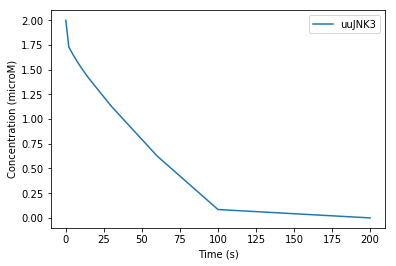

In [114]:
plt.plot(tspan[:12], sim['__s2'][:12], label='uuJNK3')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

# Figure 2. In this figure we can see how pMKK4 and pMKK7 are being used. pMKK7 gets rapidly consumed and then released, whereas pMKK4 it's slowly used and remains low, which means that it stays bound to the complexes.

Text(0,0.5,u'Concentration (microM)')

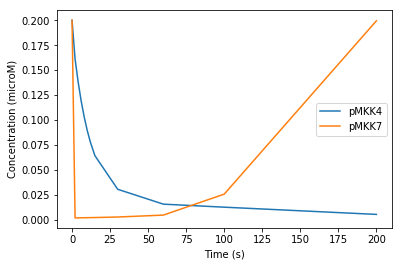

In [115]:
plt.plot(tspan[:12], sim['__s0'][:12], label='pMKK4')
plt.plot(tspan[:12], sim['__s1'][:12], label='pMKK7')

# plt.semilogx(tspan, sim['__s3'], label='uuJNK3')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

# Figure 3. In this figure we can see the dynamics of the complex formation of uuJNK3 with MKK4/7. From this, we can see that MKK7 rapidly binds to uuJNK3 and because the k_reverse = 234.50 inversed microM*s (dissociation constant) is small, the complex is more stable. On the other hand, for MKK4 we have k_reverse = 434163.36 which makes the MKK4%uuJNK3 complex more unstable and that's why it doesn't accumulate that much over time.

In [218]:
print (param_values[24], 'kcat MKK4')
print (param_values[25], 'kcat MKK7')
print (param_values[17], 'kr MKK4 bind to JNK3')
print (param_values[19], 'kr MKK7 bind to JNK3')
print (param_values[33], 'kr MKK4 bind to uJNK3')
print (param_values[35], 'kr MKK7 bind to uJNK3')

(1.4005931958394613, 'kcat MKK4')
(0.08513195834607554, 'kcat MKK7')
(434163.3694724599, 'kr MKK4 bind to JNK3')
(234.50454168164578, 'kr MKK7 bind to JNK3')
(61.07278631338008, 'kr MKK4 bind to uJNK3')
(18631074.635184627, 'kr MKK7 bind to uJNK3')


Text(0,0.5,u'Concentration (microM)')

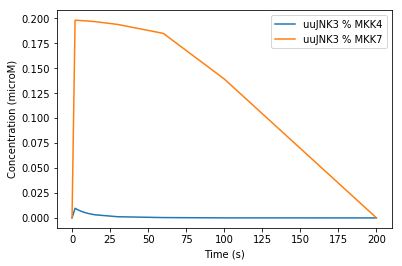

In [176]:
plt.plot(tspan[:12], sim['__s3'][:12], label='uuJNK3 % MKK4')
plt.plot(tspan[:12], sim['__s4'][:12], label='uuJNK3 % MKK7')
# plt.plot(tspan[:12], sim['__s6'][:12], label='upJNK3 % MKK4')
# plt.plot(tspan, sim['__s7'], label='puJNK3 % MKK7')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

# Figure 4. Here, we have that the puJNK3%MKK7 complex (Thr phosphorylation by MKK7)  doesn't accumulate because the rate of creation is similiar to the rate of consumption as we can see in figure 5. On the other hand, the upJNK3%MKK4 complex (Tyr phosphorylation by MKK4) accumulates over time and then its concentration decreases when the dissociation rate is larger than the creation rate as we can see in figure 6

Text(0,0.5,u'Concentration (microM)')

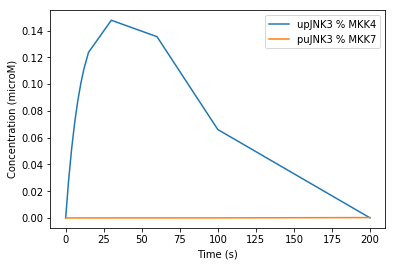

In [200]:
plt.plot(tspan[:12], sim['__s5'][:12], label='upJNK3 % MKK4')
plt.plot(tspan[:12], sim['__s6'][:12], label='puJNK3 % MKK7')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

# Figure 5. Comparation of the formation and dissociation rates of the puJNK3%MKK7 complex.

Text(0,0.5,u'Rate microM/s')

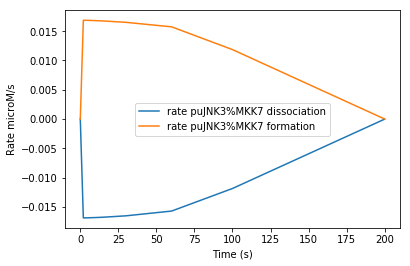

In [206]:
plt.plot(tspan[:12], sim['__s1'][:12]*sim['__s8'][:12]*15000.0-sim['__s6'][:12]*18631074.635184627, label='rate puJNK3%MKK7 dissociation')
plt.plot(tspan[:12], sim['__s4'][:12]*0.08513195834607554, label='rate puJNK3%MKK7 formation')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rate microM/s')

# Figure 6. Comparation of the formation and dissociation rates of the upJNK3%MKK4 complex.

Text(0,0.5,u'Rate microM/s')

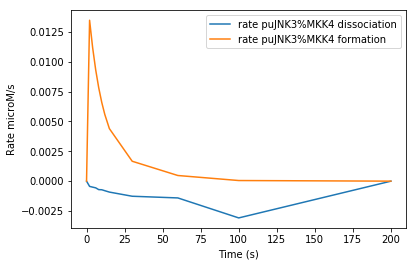

In [210]:
plt.plot(tspan[:12], sim['__s0'][:12]*sim['__s7'][:12]*15000.0-sim['__s5'][:12]*61.07278631338008, label='rate puJNK3%MKK4 dissociation')
plt.plot(tspan[:12], sim['__s3'][:12]*1.4005931958394613, label='rate puJNK3%MKK4 formation')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rate microM/s')

# Figure 7. In this figure we see that puJNK3 gets dissociated and accumulated from the puJNK3%MKK7 complex faster than the upJNK3%MKK4 complex. This implies that MKK7 phosphorylates JNK3 before MKK4 does.

Text(0,0.5,u'Concentration (microM)')

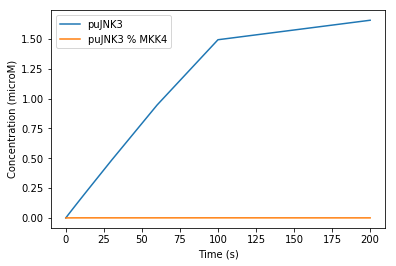

In [167]:
plt.plot(tspan[:12], sim['__s8'][:12], label='puJNK3')
plt.plot(tspan[:12], sim['__s9'][:12], label='puJNK3 % MKK4')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

# Figure 8. Here, we can see that there is a portion of the activated JNK3 where MKK4 phosphorylates JNK3 before MKK7 does.

Text(0,0.5,u'Concentration (microM)')

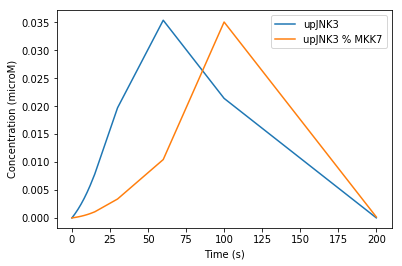

In [216]:
plt.plot(tspan[:12], sim['__s7'][:12], label='upJNK3')
plt.plot(tspan[:12], sim['__s10'][:12], label='upJNK3 % MKK7')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

Text(0,0.5,u'Concentration (microM)')

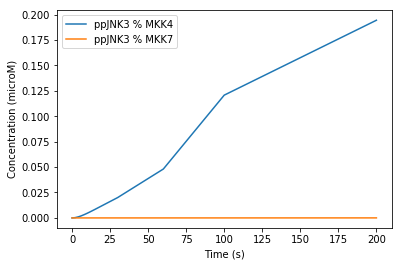

In [214]:
plt.plot(tspan[:12], sim['__s11'][:12], label='ppJNK3 % MKK4')
plt.plot(tspan[:12], sim['__s12'][:12], label='ppJNK3 % MKK7')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

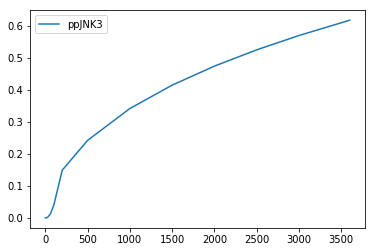

In [18]:
plt.plot(tspan, sim['__s13'], label='ppJNK3')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Concentration (microM)')

In [131]:
from tropical.dynamic_signatures_range import run_tropical

tspan = [0, 2, 4, 6, 8, 10, 12, 15, 30, 60, 100, 200, 300, 400, 500, 1000, 2000, 2500, 3600]
solver = ScipyOdeSimulator(model_simple, tspan=tspan)
# param_values[36] = 0
sim_t = solver.run(param_values=param_values)


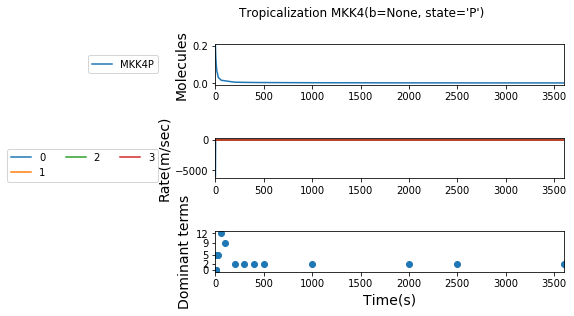

In [98]:
signatures = run_tropical(model_simple, simulations=sim_t, diff_par=1, sp_to_vis=[0], plot_type=1)

Text(0,0.5,u'rate (microM/s)')

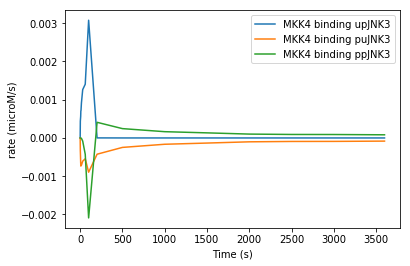

In [121]:
# plt.plot(tspan[:10], -sim['__s0'][:10]*sim['__s2'][:10]*1.5e4 + sim['__s3'][:10]*434163.3694724599, label='MKK4 binding uuJNK3')
plt.plot(tspan[:], -sim['__s0'][:]*sim['__s7'][:]*1.5e4 + sim['__s5'][:]*61.07278631338008, label='MKK4 binding upJNK3')
plt.plot(tspan[:], -sim['__s0'][:]*sim['__s8'][:]*1.5e4 + sim['__s9'][:]*434163.3694724599, label='MKK4 binding puJNK3')
plt.plot(tspan[:], -sim['__s0'][:]*sim['__s13'][:]*1.5e4 + sim['__s11'][:]*61.07278631338008, label='MKK4 binding ppJNK3')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('rate (microM/s)')

In [80]:
-sim['__s0'][:10]*sim['__s7'][:10]*1.5e4 + sim['__s5'][:10]*61.07278631338008

array([0.        , 0.00043869, 0.00050146, 0.0005604 , 0.00070916,
       0.0007204 , 0.00080008, 0.00091571, 0.00126418, 0.00140532])

In [69]:
signatures['species_combinations'][0]['reactants']

OrderedDict([(1,
              {0: (-(__s0*__s2*kf_MKK4_uJNK3 - __s3*kr_MKK4_uJNK3),),
               1: (-__s0*__s7*kf_pJNK3_MKK4complex + __s5*kr_pJNK3_MKK4complex,),
               2: (-(__s0*__s8*kf_MKK4_uJNK3 - __s9*kr_MKK4_uJNK3),),
               3: (-__s0*__s13*kf_pJNK3_MKK4complex + __s11*kr_pJNK3_MKK4complex,)}),
             (2,
              {4: (-(__s0*__s2*kf_MKK4_uJNK3 - __s3*kr_MKK4_uJNK3),
                -__s0*__s7*kf_pJNK3_MKK4complex + __s5*kr_pJNK3_MKK4complex),
               5: (-(__s0*__s2*kf_MKK4_uJNK3 - __s3*kr_MKK4_uJNK3),
                -(__s0*__s8*kf_MKK4_uJNK3 - __s9*kr_MKK4_uJNK3)),
               6: (-__s0*__s13*kf_pJNK3_MKK4complex + __s11*kr_pJNK3_MKK4complex,
                -(__s0*__s2*kf_MKK4_uJNK3 - __s3*kr_MKK4_uJNK3)),
               7: (-__s0*__s7*kf_pJNK3_MKK4complex + __s5*kr_pJNK3_MKK4complex,
                -(__s0*__s8*kf_MKK4_uJNK3 - __s9*kr_MKK4_uJNK3)),
               8: (-__s0*__s13*kf_pJNK3_MKK4complex + __s11*kr_pJNK3_MKK4complex,
  

In [186]:
print (param_values[24], 'kcat MKK4')
print (param_values[25], 'kcat MKK7')
print (param_values[17], 'kr MKK4 bind to JNK3')
print (param_values[19], 'kr MKK7 bind to JNK3')

(1.4005931958394613, 'kcat MKK4')
(0.08513195834607554, 'kcat MKK7')
(434163.3694724599, 'kr MKK4 bind to JNK3')
(234.50454168164578, 'kr MKK7 bind to JNK3')


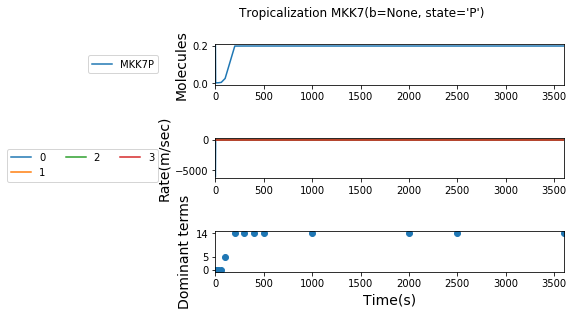

In [102]:
signatures = run_tropical(model_simple, simulations=sim_t, diff_par=1, sp_to_vis=[1], plot_type=1)

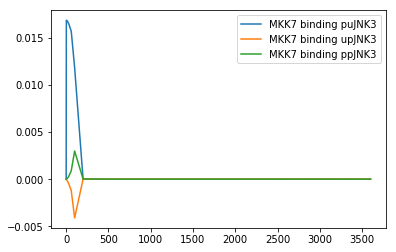

In [124]:
# plt.plot(tspan[:10], -sim['__s1'][:10]*sim['__s2'][:10]*1.5e4 + sim['__s4'][:10]*234.50454168164578, label='MKK4 binding uuJNK3')
plt.plot(tspan[:], -sim['__s1'][:]*sim['__s8'][:]*1.5e4 + sim['__s6'][:]*18631074.635184627, label='MKK7 binding puJNK3')
plt.plot(tspan[:], -sim['__s1'][:]*sim['__s7'][:]*1.5e4 + sim['__s10'][:]*234.50454168164578, label='MKK7 binding upJNK3')
plt.plot(tspan[:], -sim['__s1'][:]*sim['__s13'][:]*1.5e4 + sim['__s12'][:]*18631074.635184627, label='MKK7 binding ppJNK3')
plt.legend()

In [58]:
signatures['species_combinations'][1]['reactants']

OrderedDict([(1,
              {0: (-(__s1*__s2*kf_MKK7_uJNK3 - __s4*kr_MKK7_uJNK3),),
               1: (-__s1*__s8*kf_pJNK3_MKK7complex + __s6*kr_pJNK3_MKK7complex,),
               2: (-(__s1*__s7*kf_MKK7_uJNK3 - __s10*kr_MKK7_uJNK3),),
               3: (-__s1*__s13*kf_pJNK3_MKK7complex + __s12*kr_pJNK3_MKK7complex,)}),
             (2,
              {4: (-(__s1*__s2*kf_MKK7_uJNK3 - __s4*kr_MKK7_uJNK3),
                -__s1*__s8*kf_pJNK3_MKK7complex + __s6*kr_pJNK3_MKK7complex),
               5: (-(__s1*__s2*kf_MKK7_uJNK3 - __s4*kr_MKK7_uJNK3),
                -(__s1*__s7*kf_MKK7_uJNK3 - __s10*kr_MKK7_uJNK3)),
               6: (-__s1*__s13*kf_pJNK3_MKK7complex + __s12*kr_pJNK3_MKK7complex,
                -(__s1*__s2*kf_MKK7_uJNK3 - __s4*kr_MKK7_uJNK3)),
               7: (-(__s1*__s7*kf_MKK7_uJNK3 - __s10*kr_MKK7_uJNK3),
                -__s1*__s8*kf_pJNK3_MKK7complex + __s6*kr_pJNK3_MKK7complex),
               8: (-__s1*__s13*kf_pJNK3_MKK7complex + __s12*kr_pJNK3_MKK7complex,

In [60]:
signatures[1]

[array([ 8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  8, 14, 14, 14, 14, 14,
        14, 14]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 14, 14, 14, 14, 14, 14,
        14, 14])]

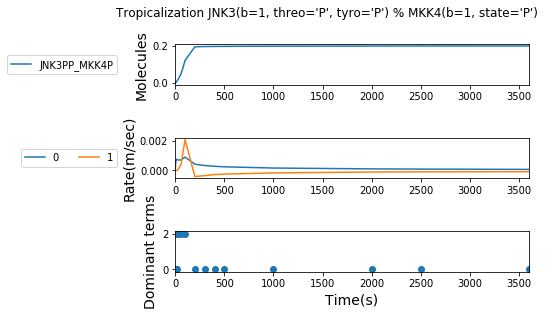

In [136]:
signatures = run_tropical(model_simple, simulations=sim_t, diff_par=1, sp_to_vis=[11], plot_type=0)

In [ ]:
a = sim.all['__s1']*sim.all['__s3']*15000.0-sim.all['__s7']*434163.3694724599
print (a)
b = -sim.all['__s7']*1.4005931958394613
print (b)
# plt.plot(tspan, a, label='a')
plt.plot(tspan, b, label='b')
plt.legend()

In [ ]:
model.odes[8]

In [ ]:
a = sim.all['__s2']*sim.all['__s3']*15000.0-sim.all['__s8']*234.50454168164578
print (a)
b = -sim.all['__s8']*0.08513195834607554
print (b)
# plt.plot(tspan, a, label='a')
plt.plot(tspan, b, label='b')
plt.legend()

In [ ]:
print(model.species[7])
print(model.species[3])

In [ ]:
param_values[25]